### # 1. 안심귀갓길 사각지대 분석 (1인가구 대비 시설 부족 자치구 찾기)

구 개수: 25
  region     total
0    강남구   79274.0
1    강동구   65601.0
2    강북구   53705.0
3    강서구  106748.0
4    관악구  153605.0
시설 매칭 구 수: 24
  region  facility_count  facility_type_diversity
0    강남구              20                        2
1    강동구              16                        2
2    강북구              20                        3
3    강서구              20                        2
4    관악구              27                        2
사각지대 후보 수: 1
   region    total  facility_count  fac_per_10k  blindspot_score
19   영등포구  79698.0               8     1.003789         1.515328


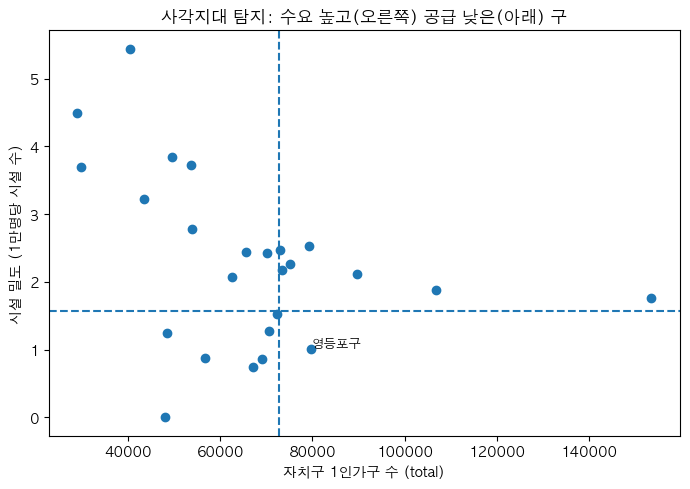

저장: outputs_1_blindspot/blindspot_scatter.png
저장: outputs_1_blindspot/blindspot_table.csv


In [4]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform

EXCEL_PATH = "서울시 1인가구수.xlsx"   
SAFE_JSON_PATH = "서울시 안심귀갓길 서비스.json"

OUTDIR = "outputs_1_blindspot"
os.makedirs(OUTDIR, exist_ok=True)

def set_korean_font():
    sys = platform.system()
    candidates = {
        "Darwin": ["AppleGothic"],
        "Windows": ["Malgun Gothic"],
        "Linux": ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR", "DejaVu Sans"],
    }.get(sys, ["DejaVu Sans"])
    plt.rcParams["font.family"] = candidates[0]
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# ✅ 엑셀 구조에 맞춘 파서 (0열=구, 1열=총)
def parse_single_households_excel(path: str) -> pd.DataFrame:
    raw = pd.read_excel(path, header=None)

    region = raw.iloc[:, 0].astype(str).str.strip()
    total = (
        raw.iloc[:, 1].astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    total = pd.to_numeric(total, errors="coerce")

    # '구'로 끝나는 행만 남김 + total 숫자인 행만
    m = region.str.endswith("구") & total.notna()

    gu = pd.DataFrame({"region": region[m], "total": total[m]})
    gu = gu.groupby("region", as_index=False)["total"].sum()

    return gu

def load_facilities_by_gu(json_path: str) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        j = json.load(f)
    df = pd.DataFrame(j.get("DATA", []))
    if df.empty:
        raise ValueError("SAFE_JSON_PATH의 DATA가 비어있어요.")

    # region 만들기
    if "sgg_nm" in df.columns:
        df["region"] = df["sgg_nm"].astype(str).str.strip()
        df["region"] = df["region"].str.replace("서울특별시", "", regex=False).str.strip()
    else:
        if "de_loc" not in df.columns:
            raise ValueError("JSON에 sgg_nm도 de_loc도 없어서 자치구 매칭 불가")
        def extract_gu(addr):
            if not isinstance(addr, str):
                return None
            for t in addr.split():
                if t.strip().endswith("구"):
                    return t.strip()
            return None
        df["region"] = df["de_loc"].apply(extract_gu)

    # 집계
    fac_cnt = df.dropna(subset=["region"]).groupby("region", as_index=False).size()
    fac_cnt.columns = ["region", "facility_count"]

    if "sisul_code" in df.columns:
        df["sisul_code"] = df["sisul_code"].astype(str).str.strip()
        fac_div = df.dropna(subset=["region"]).groupby("region")["sisul_code"].nunique().reset_index()
        fac_div.columns = ["region", "facility_type_diversity"]
        fac_cnt = fac_cnt.merge(fac_div, on="region", how="left")
    else:
        fac_cnt["facility_type_diversity"] = 0

    fac_cnt["facility_type_diversity"] = fac_cnt["facility_type_diversity"].fillna(0).astype(int)
    return fac_cnt

# -----------------------
# 실행
# -----------------------
gu = parse_single_households_excel(EXCEL_PATH)
print("구 개수:", len(gu))
print(gu.head())

fac = load_facilities_by_gu(SAFE_JSON_PATH)
print("시설 매칭 구 수:", len(fac))
print(fac.head())

df = gu.merge(fac, on="region", how="left")
df["facility_count"] = df["facility_count"].fillna(0).astype(int)
df["facility_type_diversity"] = df["facility_type_diversity"].fillna(0).astype(int)

# 밀도(1인가구 1만명당 시설)
df["fac_per_10k"] = df["facility_count"] / (df["total"]/10000.0 + 1e-9)

# 사각지대 정의:
hi_total_thr = df["total"].quantile(0.70)
lo_fac_thr = df["fac_per_10k"].quantile(0.30)

df["is_blindspot"] = (df["total"] >= hi_total_thr) & (df["fac_per_10k"] <= lo_fac_thr)

# 점수(정규화)
df["total_z"] = (df["total"] - df["total"].mean()) / (df["total"].std() + 1e-9)
df["fac_z"] = (df["fac_per_10k"] - df["fac_per_10k"].mean()) / (df["fac_per_10k"].std() + 1e-9)
df["blindspot_score"] = df["total_z"] - df["fac_z"]

blind = df[df["is_blindspot"]].sort_values("blindspot_score", ascending=False)
print("사각지대 후보 수:", len(blind))
print(blind[["region","total","facility_count","fac_per_10k","blindspot_score"]].head(10))

# 시각화
plt.figure(figsize=(7,5))
plt.scatter(df["total"], df["fac_per_10k"])

for _, r in df.iterrows():
    if r["is_blindspot"]:
        plt.text(r["total"], r["fac_per_10k"], r["region"], fontsize=9, ha="left", va="bottom")

plt.axvline(hi_total_thr, linestyle="--")
plt.axhline(lo_fac_thr, linestyle="--")
plt.xlabel("자치구 1인가구 수 (total)")
plt.ylabel("시설 밀도 (1만명당 시설 수)")
plt.title("사각지대 탐지: 수요 높고(오른쪽) 공급 낮은(아래) 구")
plt.tight_layout()

out_png = os.path.join(OUTDIR, "blindspot_scatter.png")
plt.savefig(out_png, dpi=200)
plt.show()

out_csv = os.path.join(OUTDIR, "blindspot_table.csv")
df.sort_values("blindspot_score", ascending=False).to_csv(out_csv, index=False, encoding="utf-8-sig")

print("저장:", out_png)
print("저장:", out_csv)


### 2. 자치구 유형화(군집) & 군집별 특징 요약

In [ ]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from numpy.linalg import norm

EXCEL_PATH = "서울시 1인가구수.xlsx"
SAFE_JSON_PATH = "서울시 안심귀갓길 서비스.json"

OUTDIR = "outputs_2_clustering"
os.makedirs(OUTDIR, exist_ok=True)

def set_korean_font():
    sys = platform.system()
    candidates = {
        "Darwin": ["AppleGothic"],
        "Windows": ["Malgun Gothic"],
        "Linux": ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR", "DejaVu Sans"],
    }.get(sys, ["DejaVu Sans"])
    plt.rcParams["font.family"] = candidates[0]
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# 엑셀: 0열=자치구명, 1열=1인가구수 (상단 헤더 행 자동 제거)
def parse_single_households_excel(path: str) -> pd.DataFrame:
    raw = pd.read_excel(path, header=None)

    region = raw.iloc[:, 0].astype(str).str.strip()
    total = (
        raw.iloc[:, 1].astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    total = pd.to_numeric(total, errors="coerce")

    m = region.str.endswith("구") & total.notna()
    gu = pd.DataFrame({"region": region[m], "total": total[m]})
    gu = gu.groupby("region", as_index=False)["total"].sum()
    return gu

def load_facilities_by_gu(json_path: str) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        j = json.load(f)
    df = pd.DataFrame(j.get("DATA", []))
    if df.empty:
        raise ValueError("SAFE_JSON_PATH의 DATA가 비어있어요.")

    # region 만들기
    if "sgg_nm" in df.columns:
        df["region"] = df["sgg_nm"].astype(str).str.strip()
        df["region"] = df["region"].str.replace("서울특별시", "", regex=False).str.strip()
    else:
        if "de_loc" not in df.columns:
            raise ValueError("JSON에 sgg_nm/de_loc가 없어서 자치구 매칭 불가")
        def extract_gu(addr):
            if not isinstance(addr, str):
                return None
            for t in addr.split():
                if t.strip().endswith("구"):
                    return t.strip()
            return None
        df["region"] = df["de_loc"].apply(extract_gu)

    fac_cnt = df.dropna(subset=["region"]).groupby("region", as_index=False).size()
    fac_cnt.columns = ["region","facility_count"]

    if "sisul_code" in df.columns:
        df["sisul_code"] = df["sisul_code"].astype(str).str.strip()
        fac_div = df.dropna(subset=["region"]).groupby("region")["sisul_code"].nunique().reset_index()
        fac_div.columns = ["region","facility_type_diversity"]
        fac_cnt = fac_cnt.merge(fac_div, on="region", how="left")
    else:
        fac_cnt["facility_type_diversity"] = 0

    fac_cnt["facility_type_diversity"] = fac_cnt["facility_type_diversity"].fillna(0).astype(int)
    return fac_cnt

# ---------------------------
# 1) 로드/머지
# ---------------------------
gu = parse_single_households_excel(EXCEL_PATH)
print("구 개수:", len(gu))
print(gu.head())

fac = load_facilities_by_gu(SAFE_JSON_PATH)
print("시설 매칭 구 수:", len(fac))
print(fac.head())

df = gu.merge(fac, on="region", how="left")
df["facility_count"] = df["facility_count"].fillna(0).astype(int)
df["facility_type_diversity"] = df["facility_type_diversity"].fillna(0).astype(int)
df["fac_per_10k"] = df["facility_count"] / (df["total"]/10000.0 + 1e-9)
df["log_total"] = np.log1p(df["total"])

# ✅ sanity check: df가 비면 여기서 멈추게
if len(df) == 0:
    raise ValueError("df가 비었어요. EXCEL_PATH/JSON_PATH 또는 region 파싱을 확인해야 해요.")

# ---------------------------
# 2) 군집화
# ---------------------------
feature_cols = ["log_total", "facility_count", "facility_type_diversity", "fac_per_10k"]
X = df[feature_cols].values
Xs = StandardScaler().fit_transform(X)

best_k, best_s = None, -1
scores = []
for k in range(2, min(7, len(df))):  # ✅ 데이터 수보다 크게 잡지 않기
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    s = silhouette_score(Xs, labels)
    scores.append((k, s))
    if s > best_s:
        best_s, best_k = s, k

print("silhouette:", scores)
print("best_k:", best_k, "score:", best_s)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster"] = km.fit_predict(Xs)

# ---------------------------
# 3) 군집 요약/대표 구
# ---------------------------
summary = df.groupby("cluster")[["total","facility_count","facility_type_diversity","fac_per_10k"]].agg(["mean","median","min","max"])
display(summary)

centers = km.cluster_centers_
rep = []
for c in sorted(df["cluster"].unique()):
    idx = df[df["cluster"] == c].index.tolist()
    dists = [norm(Xs[i] - centers[c]) for i in idx]
    best_idx = idx[int(np.argmin(dists))]
    rep.append((c, df.loc[best_idx, "region"]))
print("군집별 대표 구:", rep)

# ---------------------------
# 4) 저장
# ---------------------------
df_out = df.sort_values(["cluster","total"], ascending=[True, False])
out_csv = os.path.join(OUTDIR, "clusters_with_features.csv")
df_out.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("저장:", out_csv)
df_out.head()

"""
Cluster 0 : 1인가구 적고, 시설은 평균 이상인 구
Cluster 1 : 1인가구 많지만 시설이 부족한 구
Cluster 2 : 1인가구 매우 많고, 시설도 그나마 있는 핵심 구
Cluster 3 : 데이터 특이 / 사각 행정 구
- 시설 수가 극단적으로 낮거나 0
- 다른 구들과 패턴이 안 맞아서 따로 분리됨
"""

구 개수: 25
  region     total
0    강남구   79274.0
1    강동구   65601.0
2    강북구   53705.0
3    강서구  106748.0
4    관악구  153605.0
시설 매칭 구 수: 24
  region  facility_count  facility_type_diversity
0    강남구              20                        2
1    강동구              16                        2
2    강북구              20                        3
3    강서구              20                        2
4    관악구              27                        2
silhouette: [(2, 0.3329403158384722), (3, 0.3483866635210692), (4, 0.36283345854367455), (5, 0.3250710481497817), (6, 0.3316960947173229)]
best_k: 4 score: 0.36283345854367455


total                             facility_count             \
                 mean   median      min       max           mean median min   
cluster                                                                       
0        42792.142857  43347.0  28968.0   53858.0      16.285714   15.0  11   
1        63871.142857  67182.0  48442.0   72355.0       7.857143    6.0   5   
2        87398.444444  75148.0  65601.0  153605.0      18.888889   18.0  16   
3        63792.000000  63792.0  47886.0   79698.0       4.000000    4.0   0   

            facility_type_diversity                fac_per_10k            \
        max                    mean median min max        mean    median   
cluster                                                                    
0        22                2.142857    2.0   2   3    3.886112  3.724048   
1        13                2.142857    2.0   2   3    1.228935  1.238595   
2        27                2.111111    2.0   2   3    2.227084  2.262203   
3         8                0.500000    0.5   0   1    0.501895  0.501895   

                             
              min       max  
cluster                      
0        2.785102  5.439486  
1        0.744247  2.075616  
2        1.757755  2.522895  
3        0.000000  1.003789

군집별 대표 구: [(0, '서초구'), (1, '은평구'), (2, '강남구'), (3, '양천구')]
저장: outputs_2_clustering/clusters_with_features.csv


,region,total,facility_count,facility_type_diversity,fac_per_10k,log_total,cluster
7,금천구,53858.0,15,2,2.785102,10.894125,0
2,강북구,53705.0,20,3,3.724048,10.891280,0
14,서초구,49443.0,19,2,3.842809,10.808596,0
9,도봉구,43347.0,14,2,3.229751,10.677016,0
20,용산구,40445.0,22,2,5.439486,10.607723,0


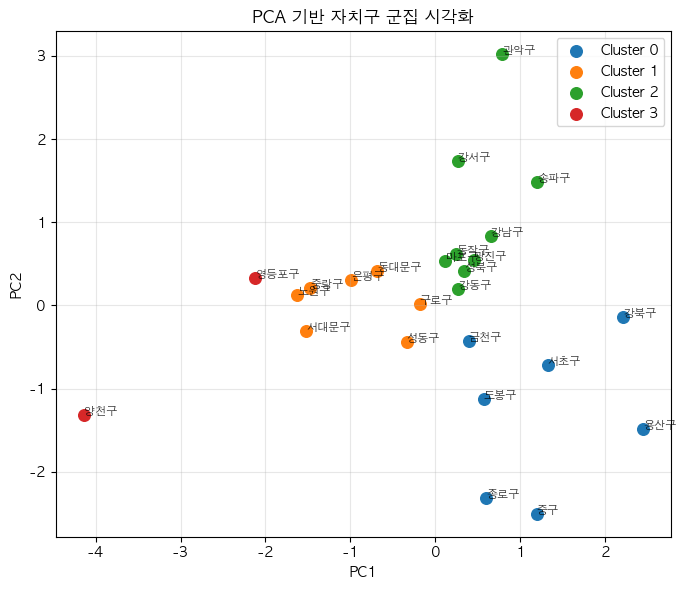

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 사용할 feature
feature_cols = ["log_total", "facility_count", "facility_type_diversity", "fac_per_10k"]

X = df[feature_cols].values
Xs = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(Xs)

df_pca = df.copy()
df_pca["PC1"] = XY[:, 0]
df_pca["PC2"] = XY[:, 1]

plt.figure(figsize=(7,6))
for c in sorted(df_pca["cluster"].unique()):
    sub = df_pca[df_pca["cluster"] == c]
    plt.scatter(sub["PC1"], sub["PC2"], label=f"Cluster {c}", s=70)

for _, r in df_pca.iterrows():
    plt.text(r["PC1"], r["PC2"], r["region"], fontsize=8, alpha=0.8)

plt.title("PCA 기반 자치구 군집 시각화")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 3. 공간 커버리지 분석 (시설/역 반경 커버리지)

✅ 시설 포인트 수: 347
✅ 역 포인트 수: 783
경도/위도 컬럼: lot lat
✅ 저장: outputs_3_coverage/coverage_by_gu.csv


/var/folders/zq/2z3yxb292_3493bpkdxm8ywr0000gn/T/ipykernel_50865/1041041015.py:139: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  safe_cov_area = safe_clip.unary_union.area
/var/folders/zq/2z3yxb292_3493bpkdxm8ywr0000gn/T/ipykernel_50865/1041041015.py:147: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  sta_cov_area = sta_clip.unary_union.area


,region,gu_area_m2,safe_cov_m2,sta_cov_m2,safe_cov_ratio,sta_cov_ratio,safe_cov_pct,sta_cov_pct
18,양천구,1.787743e+07,1.575986e+05,4.946340e+06,0.008816,0.276681,0.881551,27.668075
8,노원구,3.544206e+07,1.259088e+06,9.922443e+06,0.035525,0.279962,3.552525,27.996236
21,은평구,3.137801e+07,1.476600e+06,7.911634e+06,0.047058,0.252139,4.705842,25.213944
13,서대문구,1.739523e+07,1.408522e+06,5.082624e+06,0.080972,0.292185,8.097172,29.218485
14,서초구,4.781236e+07,4.082584e+06,1.259835e+07,0.085388,0.263496,8.538763,26.349570
22,종로구,2.387694e+07,2.130298e+06,6.110115e+06,0.089220,0.255900,8.921988,25.590025
24,중랑구,1.796618e+07,1.649085e+06,8.312641e+06,0.091788,0.462683,9.178831,46.268265
3,강서구,4.299512e+07,3.982585e+06,1.267201e+07,0.092629,0.294731,9.262878,29.473130
0,강남구,3.840897e+07,3.879090e+06,1.722780e+07,0.100994,0.448536,10.099439,44.853594
15,성동구,1.656064e+07,1.680800e+06,9.727676e+06,0.101494,0.587398,10.149367,58.739752


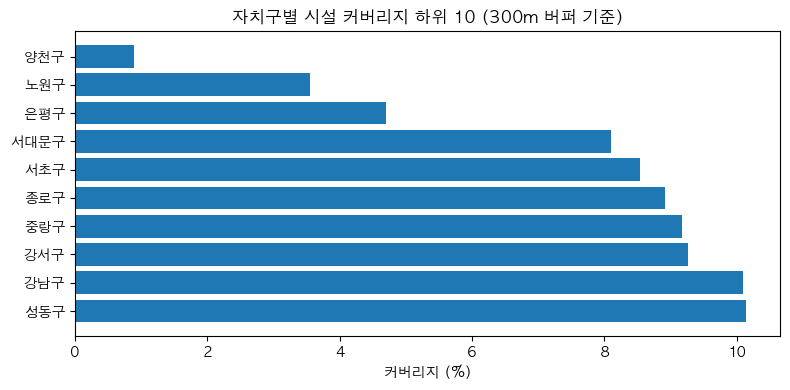

In [ ]:
import os, json
import numpy as np
import pandas as pd
import geopandas as gpd

# =========================
# 경로
# =========================
SAFE_JSON_PATH = "서울시 안심귀갓길 서비스.json"
STATION_JSON_PATH = "서울시 역사마스터 정보.json"   # 업로드된 파일 경로
GEOJSON_PATH = "hangjeongdong_서울특별시.geojson"           # 자치구 경계(있으면)

OUTDIR = "outputs_3_coverage"
os.makedirs(OUTDIR, exist_ok=True)

# =========================
# 유틸: JSON 로드 (pd.read_json보다 안정적)
# =========================
def load_json_to_df(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)

    # 1) {"DATA":[...]} 형태
    if isinstance(obj, dict) and "DATA" in obj:
        return pd.DataFrame(obj["DATA"])

    # 2) 그냥 리스트([...]) 형태
    if isinstance(obj, list):
        return pd.DataFrame(obj)

    # 3) dict 안에 다른 키로 리스트가 있을 때(추측)
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(v, list):
                return pd.DataFrame(v)

    raise ValueError(f"JSON 구조를 파악할 수 없음: {path}")

# =========================
# 1) 시설 포인트 GeoDataFrame
# =========================
df_safe = load_json_to_df(SAFE_JSON_PATH)
df_safe["longitude"] = pd.to_numeric(df_safe.get("longitude"), errors="coerce")
df_safe["latitude"]  = pd.to_numeric(df_safe.get("latitude"), errors="coerce")
df_safe = df_safe.dropna(subset=["longitude", "latitude"])

g_safe = gpd.GeoDataFrame(
    df_safe,
    geometry=gpd.points_from_xy(df_safe["longitude"], df_safe["latitude"]),
    crs="EPSG:4326"
)

print("✅ 시설 포인트 수:", len(g_safe))

# =========================
# 2) 역 포인트 GeoDataFrame
#   - 역사마스터: lot=경도, lat=위도, route=호선, bldn_nm=역명 (너가 말한 기준)
# =========================
station_df = load_json_to_df(STATION_JSON_PATH)

# 컬럼명이 lot/lat가 아닐 수도 있어서 대응
# (혹시 lon/lat, longitude/latitude이면 아래 후보에 넣어서 자동 매핑)
lon_candidates = ["lot", "lon", "lng", "longitude", "LON", "LONGITUDE"]
lat_candidates = ["lat", "latitude", "LAT", "LATITUDE"]

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

lon_col = pick_col(station_df, lon_candidates)
lat_col = pick_col(station_df, lat_candidates)

if lon_col is None or lat_col is None:
    raise ValueError(f"역사마스터에서 경도/위도 컬럼을 못 찾았어요. 현재 컬럼: {list(station_df.columns)}")

station_df[lon_col] = pd.to_numeric(station_df[lon_col], errors="coerce")
station_df[lat_col] = pd.to_numeric(station_df[lat_col], errors="coerce")
station_df = station_df.dropna(subset=[lon_col, lat_col])

g_sta = gpd.GeoDataFrame(
    station_df,
    geometry=gpd.points_from_xy(station_df[lon_col], station_df[lat_col]),
    crs="EPSG:4326"
)

print("✅ 역 포인트 수:", len(g_sta))
print("경도/위도 컬럼:", lon_col, lat_col)

# =========================
# 3) 자치구 폴리곤 로드 + 커버리지 계산
# =========================
if not os.path.exists(GEOJSON_PATH):
    print("⚠️ GeoJSON이 없어서 자치구별 커버리지율은 계산 못해요.")
    print("   대신 시설/역 포인트는 정상 로드됨.")
else:
    g = gpd.read_file(GEOJSON_PATH)

    if "sggnm" not in g.columns:
        raise ValueError(f"GeoJSON에 sggnm(자치구명) 컬럼이 필요해요. 현재 컬럼: {list(g.columns)}")

    g["sggnm"] = g["sggnm"].astype(str).str.strip()

    # 행정동 -> 자치구 dissolve
    g_gu = g.dissolve(by="sggnm", as_index=False)
    g_gu = g_gu.set_geometry("geometry").set_crs(g.crs)

    # 거리 계산 위해 미터 CRS
    target_crs = "EPSG:5179"
    g_gu_m   = g_gu.to_crs(target_crs)
    g_safe_m = g_safe.to_crs(target_crs)
    g_sta_m  = g_sta.to_crs(target_crs)

    # 반경 (원하면 여기만 바꾸면 됨)
    SAFE_R = 300
    STA_R  = 500

    safe_buf = g_safe_m[["geometry"]].copy()
    safe_buf["geometry"] = safe_buf.geometry.buffer(SAFE_R)

    sta_buf = g_sta_m[["geometry"]].copy()
    sta_buf["geometry"] = sta_buf.geometry.buffer(STA_R)

    # ✅ 공간 인덱스 (속도 개선 핵심)
    safe_sindex = safe_buf.sindex
    sta_sindex  = sta_buf.sindex

    rows = []
    for _, gu_row in g_gu_m.iterrows():
        gu_name = gu_row["sggnm"]
        gu_geom = gu_row.geometry
        gu_area = gu_geom.area

        # ---- 시설 버퍼 후보만 추출
        safe_idx = list(safe_sindex.intersection(gu_geom.bounds))
        if safe_idx:
            safe_clip = safe_buf.iloc[safe_idx].geometry.intersection(gu_geom)
            safe_cov_area = safe_clip.unary_union.area
        else:
            safe_cov_area = 0.0

        # ---- 역 버퍼 후보만 추출
        sta_idx = list(sta_sindex.intersection(gu_geom.bounds))
        if sta_idx:
            sta_clip = sta_buf.iloc[sta_idx].geometry.intersection(gu_geom)
            sta_cov_area = sta_clip.unary_union.area
        else:
            sta_cov_area = 0.0

        rows.append({
            "region": gu_name,
            "gu_area_m2": gu_area,
            "safe_cov_m2": safe_cov_area,
            "sta_cov_m2": sta_cov_area,
            "safe_cov_ratio": safe_cov_area / (gu_area + 1e-9),
            "sta_cov_ratio": sta_cov_area / (gu_area + 1e-9),
        })

    cov = pd.DataFrame(rows)

    # 보기 좋게 %
    cov["safe_cov_pct"] = cov["safe_cov_ratio"] * 100
    cov["sta_cov_pct"]  = cov["sta_cov_ratio"] * 100

    cov = cov.sort_values("safe_cov_ratio")  # 시설 커버리지 낮은 구부터
    out_csv = os.path.join(OUTDIR, "coverage_by_gu.csv")
    cov.to_csv(out_csv, index=False, encoding="utf-8-sig")

    print("✅ 저장:", out_csv)
    display(cov.head(10))

    # (옵션) 커버리지 하위 10개 막대그래프
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    sub = cov.head(10).iloc[::-1]  # 역순으로 보기
    plt.barh(sub["region"], sub["safe_cov_pct"])
    plt.title("자치구별 시설 커버리지 하위 10 (300m 버퍼 기준)")
    plt.xlabel("커버리지 (%)")
    plt.tight_layout()
    plt.show()

    """
    커버리지: 안심귀갓길 시설이 '얼마나 넓은 면적을 보호하고 있는가?'
    시설 커버리지율 = 자치구 내에서 시설반경 (300m)에 포함되는 면적 / 자치구 전체 면적
    
   커버리지 상위 구
   - 어디서든 조금만 걸으면, 안심귀갓길 시설 반경 들어감

   커버리지 하위 구
   - 특정 몇군데만 시설 존재. 나머지, 사각지대

    """
